In [ ]:
# Install required packages.
import os

!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.3 MB/s eta 0:13:03tcmalloc: large alloc 1147494400 bytes == 0x3a844000 @  0x7f766e276615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 1.3 MB/s eta 0:10:26tcmalloc: large alloc 1434370048 bytes == 0x7ee9a000 @  0x7f766e276615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |███████████████████████▎        | 

In [ ]:
pip install deepchem==2.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 18.5 MB/s 
     |████████████████████████████████| 29.3 MB 98.7 MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
import deepchem as dc
import torch.nn as nn
from torch.nn import Linear,BatchNorm1d
from torch_geometric.nn import GCNConv,GATv2Conv
from torch_geometric.nn import BatchNorm
from tqdm import tqdm
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('raw/totalData.csv')
data.head() 

,Unnamed: 0,Drug1_ID,Drug1_SMILES
0,0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1,1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...
2,2,DB00855,NCC(=O)CCC(O)=O
3,3,DB09536,O=[Ti]=O
4,4,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1


In [ ]:
remove = []

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.sz = 0
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            if type(mol["Drug1_SMILES"])==float:
              remove.append(mol["Drug1_ID"])
              continue
            f = featurizer.featurize(mol["Drug1_SMILES"])
            if not f : 
              remove.append(mol["Drug1_ID"])
              print(count)
              continue
            data = f[0].to_pyg_graph()
            data.y = 1
            data.smiles = mol["Drug1_SMILES"]
            data.id = mol["Drug1_ID"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_test_{count}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_{count}.pt'))
            count+=1
        self.sz = count

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.sz
        #return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

encoder_set = MoleculeDataset("","totalData.csv")

Processing...
  0%|          | 1/1705 [00:00<05:46,  4.92it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, None. Appending empty array
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
  1%|          | 16/1705 [00:00<00:36, 46.29it/s]

6


  5%|▌         | 89/1705 [00:02<00:25, 62.48it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array


82
83
85
90


 51%|█████▏    | 878/1705 [00:20<00:08, 97.87it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, None. Appending empty array
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
 52%|█████▏    | 889/1705 [00:20<00:08, 98.98it/s]

881


 59%|█████▉    | 1013/1705 [00:21<00:05, 124.35it/s]

987


 65%|██████▌   | 1116/1705 [00:23<00:10, 57.36it/s]

1090


 67%|██████▋   | 1137/1705 [00:23<00:08, 63.51it/s]

1116


 68%|██████▊   | 1166/1705 [00:24<00:08, 66.08it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, None. Appending empty array
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
 70%|██████▉   | 1187/1705 [00:24<00:06, 76.67it/s]

1158


 72%|███████▏  | 1230/1705 [00:24<00:05, 81.39it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, None. Appending empty array
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
 73%|███████▎  | 1249/1705 [00:25<00:06, 68.35it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, None. Appending empty array
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)


1225
1230
1238


 85%|████████▍ | 1446/1705 [00:27<00:02, 96.49it/s]

1417


 87%|████████▋ | 1480/1705 [00:27<00:02, 103.56it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, [Fe]. Appending empty array


1455
1465


 90%|█████████ | 1543/1705 [00:28<00:01, 94.66it/s]

1508
1510
1516


 94%|█████████▍| 1604/1705 [00:30<00:02, 41.57it/s]

1579


100%|█████████▉| 1698/1705 [00:31<00:00, 106.12it/s]WARNING:deepchem.feat.base_classes:Failed to featurize datapoint 0, [Al+3].[Al+3].[O-2].[O-2].[O-2]. Appending empty array


1657
1660
1668
1671
1671


100%|██████████| 1705/1705 [00:32<00:00, 52.15it/s] 
Done!


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
len(encoder_set)

1676

In [ ]:
class GVAE(nn.Module):
    def __init__(self, feature_size):
        super(GVAE, self).__init__()
        self.encoder_embedding_size = 64
        edge_dim = 11
        self.latent_embedding_size = 8
        self.decoder_hidden_neurons = 64
        decoder_size = 64

        # Encoder layers
        # self.conv1 = GCNConv(feature_size, self.encoder_embedding_size)
        self.conv1 = GATv2Conv(feature_size, self.encoder_embedding_size,
                             edge_dim=edge_dim, heads=4, concat=False, beta=True)
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = GATv2Conv(self.encoder_embedding_size, self.encoder_embedding_size,
                             edge_dim=edge_dim, heads=4, concat=False, beta=True)
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        self.conv3 = GATv2Conv(self.encoder_embedding_size, self.encoder_embedding_size,
                             edge_dim=edge_dim, heads=4, concat=False, beta=True)
        self.bn3 = BatchNorm(self.encoder_embedding_size)
        

        # Latent transform layers
        self.mu_transform = GATv2Conv(self.encoder_embedding_size, self.latent_embedding_size, 
                                   heads=4, concat=False, beta=True, edge_dim=edge_dim)
        self.logvar_transform = GATv2Conv(self.encoder_embedding_size, self.latent_embedding_size, 
                                       heads=4, concat=False, beta=True, edge_dim=edge_dim)
        

        
        self.decoder_dense_2 = Linear(self.latent_embedding_size*2, decoder_size)
        self.decoder_bn_2 = BatchNorm1d(decoder_size)
        self.decoder_dense_3 = Linear(self.latent_embedding_size*2, decoder_size)
        self.decoder_bn_3 = BatchNorm1d(decoder_size)
        self.decoder_dense_4 = Linear(decoder_size, 1)
        

    def encode(self, x, edge_attr, edge_index, batch_index):
        # GNN layers
        x = self.conv1(x, edge_index, edge_attr).relu()
        # x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index, edge_attr).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index, edge_attr).relu()
        x = self.bn3(x)
        
        # Latent transform layers
        mu = self.mu_transform(x, edge_index, edge_attr)
        logvar = self.logvar_transform(x, edge_index, edge_attr)
        return mu, logvar


    def decode(self, z, batch_index):
        """
        Takes n latent vectors (one per node) and decodes them
        into the upper triangular part of their adjacency matrix.
        """
        inputs = []

        # Iterate over molecules in batch
        for graph_id in torch.unique(batch_index):
            graph_mask = torch.eq(batch_index, graph_id)
            graph_z = z[graph_mask]

            # Get indices for triangular upper part of adjacency matrix
            # graph_z.shape[0] = number of nodes | triu_indices()=gives edge_indices for the graph
            edge_indices = torch.triu_indices(graph_z.shape[0], graph_z.shape[0], offset=1)

            # Repeat indices to match dim of latent codes
            dim = self.latent_embedding_size
            source_indices = torch.reshape(edge_indices[0].repeat_interleave(dim), (edge_indices.shape[1], dim))
            target_indices = torch.reshape(edge_indices[1].repeat_interleave(dim), (edge_indices.shape[1], dim))

            # Gather features=sampled latent vectors
            sources_feats = torch.gather(graph_z, 0, source_indices.to(device))
            target_feats = torch.gather(graph_z, 0, target_indices.to(device))

            # Concatenate inputs of all source and target nodes
            # graph_input shape = [no of pairs of nodes, dimension of each pair]
            graph_inputs = torch.cat([sources_feats, target_feats], axis=1)
            inputs.append(graph_inputs)

        # Concatenate all inputs of all graphs in the batch
        inputs = torch.cat(inputs)

        x = self.decoder_dense_2(inputs).relu()
        x = self.decoder_bn_2(x)
        x = self.decoder_dense_3(inputs).relu()
        x = self.decoder_bn_3(x)
        edge_logits = self.decoder_dense_4(x)
   

        return edge_logits


    def reparameterize(self, mu, logvar):
        """
        The reparametrization trick is required to 
        backpropagate through the network.
        We cannot backpropagate through a "sampled"
        node as it is not deterministic.
        The trick is to separate the randomness
        from the network.
        """
        if self.training:
            # Get standard deviation
            std = torch.exp(logvar)
            # Returns random numbers from a normal distribution
            eps = torch.randn_like(std)
            # Return sampled values
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Encode the molecule
        mu, logvar = self.encode(x, edge_attr, edge_index, batch_index)
        # Sample latent vector (per atom)
        z = self.reparameterize(mu, logvar)
        # Decode latent vector into original molecule
        triu_logits = self.decode(z, batch_index) #output=triangular upper part of the matrix

        return triu_logits, mu, logvar

    
   
model = GVAE(feature_size=encoder_set[0].x.shape[1])
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GVAE(
  (conv1): GATv2Conv(30, 64, heads=4)
  (bn1): BatchNorm(64)
  (conv2): GATv2Conv(64, 64, heads=4)
  (bn2): BatchNorm(64)
  (conv3): GATv2Conv(64, 64, heads=4)
  (bn3): BatchNorm(64)
  (mu_transform): GATv2Conv(64, 8, heads=4)
  (logvar_transform): GATv2Conv(64, 8, heads=4)
  (decoder_dense_2): Linear(in_features=16, out_features=64, bias=True)
  (decoder_bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_3): Linear(in_features=16, out_features=64, bias=True)
  (decoder_bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  103825


In [ ]:
from torch_geometric.data import DataLoader

data_size = len(encoder_set)
NUM_GRAPHS_PER_BATCH = 64
frac = 0.8
train_loader = DataLoader(encoder_set[:int(data_size * frac)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(encoder_set[int(data_size * frac):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


model = model.to(device)


In [ ]:
from torch_geometric.utils import to_dense_adj

def kl_loss(mu=None, logstd=None):
    """
    Closed formula of the KL divergence for normal distributions
    """
    MAX_LOGSTD = 10
    logstd =  logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

    # Limit numeric errors
    kl_div = kl_div.clamp(max=1000)
    return kl_div

def slice_graph_targets(graph_id, batch_targets, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    # Row slice and column slice batch targets to get graph targets
    graph_targets = batch_targets[graph_mask][:, graph_mask]
    # Get triangular upper part of adjacency matrix for targets
    triu_indices = torch.triu_indices(graph_targets.shape[0], graph_targets.shape[0], offset=1)
    triu_mask = torch.squeeze(to_dense_adj(triu_indices)).bool()
    return graph_targets[triu_mask]

def slice_graph_predictions(triu_logits, graph_triu_size, start_point):

    graph_logits_triu = torch.squeeze(triu_logits[start_point:start_point + graph_triu_size])  
    return graph_logits_triu

def slice_node_features(graph_id, node_features, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    graph_node_features = node_features[graph_mask]
    return graph_node_features

  

def gvae_loss(triu_logits, edge_index, mu, logvar, batch_index, kl_beta):
    """
    Calculates a weighted ELBO loss for a batch of graphs for the graph
    variational autoencoder model.
    """
    # Convert target edge index to dense adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))

    # Reconstruction loss per graph
    batch_recon_loss = []
    batch_node_counter = 0

    # Loop over graphs in this batch
    for graph_id in torch.unique(batch_index):
        # Get upper triangular targets for this graph from the whole batch
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)

        # Get upper triangular predictions for this graph from the whole batch
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)
        
        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Calculate edge-weighted binary cross entropy
        weight = graph_targets_triu.shape[0]/sum(graph_targets_triu)
        bce = torch.nn.BCEWithLogitsLoss(pos_weight=weight).to(device)
        graph_recon_loss = bce(graph_predictions_triu.view(-1), graph_targets_triu.view(-1))
        batch_recon_loss.append(graph_recon_loss)   

    # Take average of all losses
    num_graphs = torch.unique(batch_index).shape[0]
    batch_recon_loss = sum(batch_recon_loss) / num_graphs
    
    # KL Divergence
    kl_divergence = kl_loss(mu, logvar)

    return batch_recon_loss + kl_beta * kl_divergence, kl_divergence


def reconstruction_accuracy(triu_logits, edge_index, batch_index, node_features):
    # Convert edge index to adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))
    # Store target trius
    batch_targets_triu = []
    # Iterate over batch and collect each of the trius
    batch_node_counter = 0
    num_recon = 0
    for graph_id in torch.unique(batch_index):
        # Get triu parts for this graph
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)

        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Slice node features of this batch
        graph_node_features = slice_node_features(graph_id, node_features, batch_index)

        # Check if graph is successfully reconstructed
        num_nodes = sum(torch.eq(batch_index, graph_id))
      
        batch_targets_triu.append(graph_targets_triu)
        
    batch_targets_triu = torch.cat(batch_targets_triu).detach()
    triu_discrete = torch.squeeze(torch.tensor(torch.sigmoid(triu_logits) > 0.5, dtype=torch.int32))
    acc = torch.true_divide(torch.sum(batch_targets_triu==triu_discrete), batch_targets_triu.shape[0]) 
    return acc.detach().cpu().numpy(), num_recon
    




In [ ]:
loss_fn = gvae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
kl_beta = 0.005

In [ ]:
def run_one_epoch(data_loader, type, epoch, kl_beta):
    # Store per batch loss and accuracy 
    all_losses = []
    all_accs = []

    # Iterate over data loader
    for i, batch in enumerate(tqdm(data_loader)):
        # Some of the data points have invalid adjacency matrices 
        try:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Call model
            triu_logits, mu, logvar = model(batch.x.float(), 
                                            batch.edge_attr.float(),
                                            batch.edge_index, 
                                            batch.batch) 
            # Calculate loss and backpropagate
            loss, kl_div = loss_fn(triu_logits, batch.edge_index, mu, logvar, batch.batch, kl_beta)
            if type == "Train":
                loss.backward()  
                optimizer.step()  
            # Calculate metrics
            acc = reconstruction_accuracy(triu_logits, batch.edge_index, batch.batch, batch.x.float())
            

            # Store loss and metrics
            all_losses.append(loss.detach().cpu().numpy())
            all_accs.append(acc)
            
            

        except IndexError as error:
            # For a few graphs the edge information is not correct
            # Simply skip the batch containing those
            print("Error: ", error)
    
    print(f"{type} epoch {epoch} loss: ", np.array(all_losses).mean())
    print(f"{type} epoch {epoch} accuracy: ", np.array(all_accs).mean())
   

In [ ]:
for epoch in range(6): 
  model.train()
  run_one_epoch(train_loader, type="Train", epoch=epoch, kl_beta=kl_beta)
  if epoch % 5 == 0:
      print("test epoch...")
      model.eval()
      run_one_epoch(test_loader, type="Test", epoch=epoch, kl_beta=kl_beta)

100%|██████████| 21/21 [00:16<00:00,  1.30it/s]


Train epoch 0 loss:  0.35481474
Train epoch 0 accuracy:  0.45709803984278724
test epoch...


100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


Test epoch 0 loss:  0.36904898
Test epoch 0 accuracy:  0.4438093801339467


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train epoch 1 loss:  0.33954892
Train epoch 1 accuracy:  0.4588060748009455


100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Train epoch 2 loss:  0.33362544
Train epoch 2 accuracy:  0.4596736204056513


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Train epoch 3 loss:  0.32738945
Train epoch 3 accuracy:  0.46095635635512217


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Train epoch 4 loss:  0.3165987
Train epoch 4 accuracy:  0.46200789014498395


100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Train epoch 5 loss:  0.31292105
Train epoch 5 accuracy:  0.46290324557395207
test epoch...


100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

Test epoch 5 loss:  0.34143218
Test epoch 5 accuracy:  0.4490105261405309


In [ ]:
NUM_GRAPHS_PER_BATCH = 1
loader = DataLoader(encoder_set, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

dictval = {}
for batch in loader : 
  batch.to(device)
  decode_pred, mu, logvar = model(batch.x.float(), 
                            batch.edge_attr.float(),
                            batch.edge_index, 
                            batch.batch) 
  
  
  dictval[batch.id[0]] = [mu,logvar]
  
print("done!!!")      

done!!!


In [ ]:
temp = pd.read_csv("drugbankbinary_train.csv")
temp.head()

,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,81088,18331,47029,DB00420,CN(C)CCCN1C2=CC=CC=C2SC2=CC=CC=C12,DB09119,CC(=O)O[C@H]1CC2=CC=CC=C2N(C(N)=O)C2=CC=CC=C12,0
1,1,109505,46748,160842,DB00289,CNCC[C@@H](OC1=CC=CC=C1C)C1=CC=CC=C1,DB00932,[H][C@@](CC)(C1=CC(NS(=O)(=O)C2=NC=C(C=C2)C(F)...,0
2,2,11901,11901,79706,DB00492,CCC(=O)O[C@@H](OP(=O)(CCCCC1=CC=CC=C1)CC(=O)N1...,DB00598,CC(CCC1=CC=CC=C1)NCC(O)C1=CC(C(N)=O)=C(O)C=C1,1
3,3,121325,58568,172662,DB09049,COCCOCCOCCOCCOCCOCCOCCO[C@H]1CC[C@@]2(O)[C@H]3...,DB00333,CCC(=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C1=CC=CC=C1,0
4,4,43610,43610,111415,DB08897,OC(C(=O)O[C@H]1C[N+]2(CCCOC3=CC=CC=C3)CCC1CC2)...,DB01192,[H][C@@]12OC3=C(O)C=CC4=C3[C@@]11CCN(C)[C@]([H...,1


In [ ]:
len(temp)

103091

In [ ]:
df = temp

# df = pd.DataFrame(columns = ['Drug1_ID', 'Drug1_SMILES', 'Drug2_ID','Drug2_SMILES','label'])

# sz = len(temp)

# for i in range(sz):
#   id1 = temp['Drug1_ID'][i]
#   id2 = temp['Drug2_ID'][i]
#   if (id1 in dictval) and (id2 in dictval) : 
#     df = df.append({'Drug1_ID' : id1, 'Drug1_SMILES' : temp['Drug1_SMILES'][i], 'Drug2_ID' : id2,'Drug2_SMILES' : temp['Drug2_SMILES'][i],'label' : temp['label'][i]}, 
#                   ignore_index = True)

# df.head()

In [ ]:
n_classes = len(df['label'].unique())
n_classes

2

In [ ]:
df['label'].value_counts()

0    55988
1    47103
Name: label, dtype: int64

In [ ]:
dftrain = df
dftest = pd.read_csv("drugbankbinary_test.csv")


In [ ]:
tempdf = temp.append(dftest)

In [ ]:
tempdf.reset_index(inplace=True)

In [ ]:
tempdf['Unnamed: 0'] = range(len(tempdf))
tempdf.drop(columns='level_0', inplace=True)

In [ ]:
tempdf.tail()

,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
137450,137450,126343,63586,177680,DB00320,[H][C@@]12CCCN1C(=O)[C@H](CC1=CC=CC=C1)N1C(=O)...,DB00881,CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N1C...,0
137451,137451,58991,58991,126796,DB01433,CCC(OC(C)=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C1=CC=CC=C1,DB09225,CN(C)CCOC1=CC2=CC=CC=C2SC2=CC=C(Cl)C=C12,1
137452,137452,60578,60578,128383,DB00455,CCOC(=O)N1CCC(CC1)=C1C2=C(CCC3=C1N=CC=C3)C=C(C...,DB00980,CCC(=O)NCC[C@@H]1CCC2=C1C1=C(OCC1)C=C2,1
137453,137453,59655,59655,127460,DB01189,FC(F)OC(F)C(F)(F)F,DB01466,[H][C@@]12OC3=C(OCC)C=CC4=C3[C@@]11CCN(C)[C@](...,1
137454,137454,9169,9169,76974,DB01545,CCOC(=O)C1N=C(C2=CC=CC=C2F)C2=C(NC1=O)C=CC(Cl)=C2,DB09128,O=C1NC2=CC(OCCCCN3CCN(CC3)C3=C4C=CSC4=CC=C3)=C...,1


In [ ]:
tempdf[103080:103110]

,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
103080,103080,113657,50900,164994,DB09075,CN(C)C(=O)[C@H]1CC[C@H](NC(=O)C(=O)NC2=NC=C(Cl...,DB00398,CNC(=O)C1=NC=CC(OC2=CC=C(NC(=O)NC3=CC(=C(Cl)C=...,0
103081,103081,5298,5298,73103,DB00575,ClC1=CC=CC(Cl)=C1NC1=NCCN1,DB01621,CN(C)S(=O)(=O)C1=CC2=C(SC3=CC=CC=C3N2CCCN2CCC(...,1
103082,103082,105411,42654,156748,DB00570,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,DB09065,CC(C)C1=NC(CN(C)C(=O)N[C@@H](CCN2CCOCC2)C(=O)N...,0
103083,103083,17127,17127,84932,DB01551,[H][C@@]12OC3=C4C(C[C@H]5N(C)CC[C@@]14[C@@]5([...,DB01567,CN1C2=C(C=C(Cl)C=C2)C(=NCC1=O)C1=CC=CC=C1F,1
103084,103084,75174,12417,41115,DB00864,CO[C@@H]1C[C@@H](CC[C@H]1O)\C=C(/C)[C@H]1OC(=O...,DB00543,ClC1=CC2=C(OC3=CC=CC=C3N=C2N2CCNCC2)C=C1,0
103085,103085,98030,35273,63971,DB00852,CN[C@@H](C)[C@@H](O)C1=CC=CC=C1,DB01156,CC(NC(C)(C)C)C(=O)C1=CC(Cl)=CC=C1,0
103086,103086,91014,28257,56955,DB06148,CN1CCN2C(C1)C1=CC=CC=C1CC1=CC=CC=C21,DB00243,COC1=CC=CC=C1OCC(O)CN1CCN(CC(=O)NC2=C(C)C=CC=C...,0
103087,103087,82302,19545,48243,DB01577,CN[C@@H](C)CC1=CC=CC=C1,DB00215,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,0
103088,103088,11958,11958,79763,DB00807,CCCOC1=C(N)C=C(C=C1)C(=O)OCCN(CC)CC,DB00575,ClC1=CC=CC(Cl)=C1NC1=NCCN1,1
103089,103089,46381,46381,114186,DB00486,[H][C@@]12CC(=O)CC[C@@]1([H])C(C)(C)OC1=CC(=CC...,DB00780,NNCCC1=CC=CC=C1,1


In [ ]:
class NumbersDataset(Dataset):
    def __init__(self,filename):
        datat = tempdf
        # datat = datat.head(partition) 
        self.samples = list(range(2*len(datat)))
        self.label = list(range(2*len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          if (str1 in dictval) and (str2 in dictval) :
            loop = 0
            if datat['label'][index]==0 :
              loop = 0
            elif datat['label'][index]==1 :
              loop = 0
            else :
              loop = 0

            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
            for genvar in range(0,loop) : 
              eps = torch.randn_like(dictval[str1][1])
              std = torch.exp(dictval[str1][1])
              mat1 = eps.mul(std).add_(dictval[str1][0])
              eps = torch.randn_like(dictval[str2][1])
              std = torch.exp(dictval[str2][1])
              mat2 = eps.mul(std).add_(dictval[str2][0])
              mean1 = torch.mean(mat1, axis = 0)
              std1 = torch.std(mat1, axis = 0)
              mean2 = torch.mean(mat2, axis = 0)
              std2 = torch.std(mat2, axis = 0)
              vect = torch.cat([mean1, mean2, std1, std2], dim=0)
              self.samples[idx] = vect.detach().cpu()
              self.label[idx] = datat['label'][index]
              self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
              idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

dataset = NumbersDataset("drugbankbinary_train.csv")
len(dataset)

135637

In [ ]:
data = dataset
data[0][0].shape[0]

32

In [ ]:
from deepchem.splits.splitters import IndexSplitter
splitter = IndexSplitter()
train_data, valid_data, test_data = splitter.split(data, frac_train=0.7, frac_valid=0.1, frac_test=0.2)

In [ ]:
print(f'Length of train data : {len(train_data)}')
print(f'Length of valid data : {len(valid_data)}')
print(f'Length of test data : {len(test_data)}')

Length of train data : 94945
Length of valid data : 13564
Length of test data : 27128


In [ ]:
data_train_val = []
for i in range(len(train_data)):
  data_train_val.append(data[train_data[i]])

In [ ]:
for i in range(len(valid_data)):
  data_train_val.append(data[valid_data[i]])

In [ ]:
data_train_val = tuple(data_train_val)

In [ ]:
len(data_train_val)

108509

In [ ]:
from sklearn.model_selection import KFold
K = 8
kfold = KFold(n_splits=K, random_state=3, shuffle=True)

In [ ]:
94946/len(data)

0.7000007372619566

In [ ]:
import torch.nn.functional as F 
torch.manual_seed(42)

class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, n_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
model_ff = NeuralNet(data[0][0].shape[0],150)
print(model_ff)
print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

NeuralNet(
  (fc1): Linear(in_features=32, out_features=150, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=150, out_features=2, bias=True)
)
Number of parameters:  5252


In [ ]:
filename = "classification.pth"
torch.save(model_ff.state_dict(), filename)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)  

# Use GPU for training
model_ff = model_ff.to(device)
loss_fn = loss_fn.to(device)

# Wrap data in a data loader
# data_size = len(data)
# NUM_GRAPHS_PER_BATCH = 128
# loader = DataLoader(data,batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



def train(data):
      # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch[0] = batch[0].to(device) 
      batch[1] = batch[1].to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      
      pred = model_ff(batch[0]) 
      
      # Calculating the loss and gradients
      
      
      loss = (loss_fn(pred, batch[1]))      
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss
  
def test(data):
  model_ff.eval()
  with torch.no_grad():
    # Enumerate over the data
      for test_batch in test_loader : 
        test_batch[0] = test_batch[0].to(device)
        test_batch[1] = test_batch[1].to(device)
        pred = model_ff(test_batch[0]) 
        pred_frac0 = pred[:,0]
        pred_frac1 = pred[:,1]
        pred = pred.argmax(dim=1)  
        dftt = pd.DataFrame()
        dftt["y_real"] = test_batch[1].tolist()
        dftt["y_pred"] = pred.tolist()
        score = f1_score(dftt['y_real'], dftt['y_pred'],average='macro')
        # print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))  
      return score

print("Starting training...")
losses = []
for fold,(x,y) in enumerate(kfold.split(data_train_val)):
  datax = []
  datay = []
  print(f'Fold {fold}')
  print(f'train_ids : {x}')
  print(f'val_ids : {y}')
  for i in range(len(x)):
    datax.append(data[x[i]])
  for n in range(len(y)):
    datay.append(data[y[n]])
  datax = tuple(datax)
  datay = tuple(datay)
  train_loader = DataLoader(datax,batch_size=128)
  test_loader = DataLoader(datay, batch_size=len(datay))
  # filename = "classification.pth"
  # model_ff.load_state_dict(torch.load(filename))
  for epoch in range(251):
      loss = train(data)
      losses.append(loss)
      if epoch % 50 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")
  filename = f'model{fold}.pth'
  torch.save(model_ff.state_dict(),filename)
  score = test(data)
  print(f'For Fold {fold} Val F1_score: {score}')

Starting training...
Fold 0
train_ids : [     1      2      3 ... 108506 108507 108508]
val_ids : [     0      5      9 ... 108485 108490 108492]
Epoch 0 | Train Loss 0.6146441698074341
Epoch 50 | Train Loss 0.42620208859443665
Epoch 100 | Train Loss 0.38969776034355164
Epoch 150 | Train Loss 0.36959224939346313
Epoch 200 | Train Loss 0.3618987500667572
Epoch 250 | Train Loss 0.3587968945503235
For Fold 0 Val F1_score: 0.9320619819572284
Fold 1
train_ids : [     0      1      2 ... 108506 108507 108508]
val_ids : [     3     23     33 ... 108465 108481 108494]
Epoch 0 | Train Loss 0.3623116910457611
Epoch 50 | Train Loss 0.37173575162887573
Epoch 100 | Train Loss 0.3647363781929016
Epoch 150 | Train Loss 0.35971391201019287
Epoch 200 | Train Loss 0.35628801584243774
Epoch 250 | Train Loss 0.3716113269329071
For Fold 1 Val F1_score: 0.9452653697955716
Fold 2
train_ids : [     0      1      2 ... 108505 108506 108507]
val_ids : [    11     15     17 ... 108488 108491 108508]
Epoch 0 | Tr

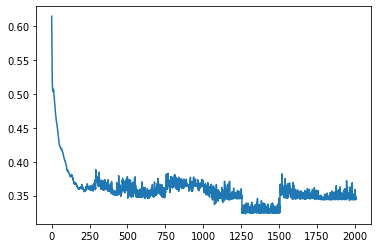

In [ ]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [ ]:
data_test = []
for i in range(len(test_data)):
  data_test.append(data[test_data[i]])

In [ ]:
data_test = tuple(data_test)

In [ ]:
len(data_test)

27128

In [ ]:
filename = "model6.pth"
classification_model = NeuralNet(data[0][0].shape[0],150)
classification_model.load_state_dict(torch.load(filename))
classification_model.eval()
classification_model.to(device)

NeuralNet(
  (fc1): Linear(in_features=32, out_features=150, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=150, out_features=2, bias=True)
)

In [ ]:
test_loader = DataLoader(data_test,batch_size=len(data_test), shuffle=True)
dffull = pd.DataFrame(columns = ['y_real','y_pred'])
with torch.no_grad():
    for test_batch in test_loader : 
      test_batch[0] = test_batch[0].to(device)
      test_batch[1] = test_batch[1].to(device)
      pred = classification_model(test_batch[0]) 
      pred_frac0 = pred[:,0]
      pred_frac1 = pred[:,1]
      if n_classes == 3 : 
        pred_frac2 = pred[:,2]
      pred = pred.argmax(dim=1)  
      dftt = pd.DataFrame()
      dftt["y_real"] = test_batch[1].tolist()
      dftt["y_pred"] = pred.tolist()
      dftt["y_predfrac0"] = pred_frac0.tolist()
      dftt["y_predfrac1"] = pred_frac1.tolist()
      if n_classes == 3 : 
        dftt["y_predfrac2"] = pred_frac2.tolist()
      dffull = dffull.append(dftt)
      print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))

dffull.to_csv('tt.csv')
dffull.tail()

0.9463870562370081


,y_real,y_pred,y_predfrac0,y_predfrac1
27123,0,0,1.000000,3.126221e-13
27124,0,0,0.998805,1.195262e-03
27125,0,0,0.998922,1.078234e-03
27126,0,0,1.000000,1.051343e-07
27127,1,1,0.038121,9.618791e-01


In [ ]:
dffull['y_real'].value_counts()

0    14723
1    12405
Name: y_real, dtype: int64

In [ ]:
dffull['y_pred'].value_counts()

0    14808
1    12320
Name: y_pred, dtype: int64

F1_score(macro) :  0.9463870562370081
F1_score(micro) :  0.9468077263344147
Accuracy :  0.9468077263344147
Confusion Matrix : 


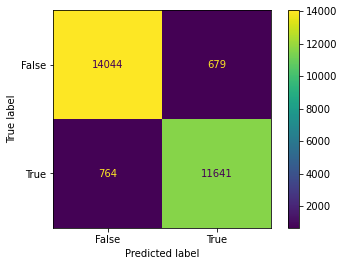

In [ ]:
datahead = pd.read_csv('tt.csv')

print("F1_score(macro) : ", f1_score(datahead['y_real'], datahead['y_pred'],average='macro'))
print("F1_score(micro) : ", f1_score(datahead['y_real'], datahead['y_pred'],average='micro'))
print("Accuracy : ", accuracy_score(datahead['y_real'], datahead['y_pred']))
print("Confusion Matrix : ")
confusion_mat = confusion_matrix(datahead['y_real'], datahead['y_pred'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
cm_display.plot()

In [ ]:
dfttt = datahead.iloc[:,3:]
dfttt.head()

,y_predfrac0,y_predfrac1
0,9.996513e-01,0.000349
1,9.999338e-01,0.000066
2,9.999816e-01,0.000018
3,3.397546e-14,1.000000
4,9.999976e-01,0.000002


In [ ]:
probab = dfttt.to_numpy()

In [ ]:
if n_classes==3 : 
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovo", average="macro")
  print(macro_roc_auc_ovo)
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovr", average="weighted")
  print(macro_roc_auc_ovo)
else : 
  auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
  print('AUC: %.3f' % auc)

AUC: 0.979


In [ ]:
if n_classes == 3 : 
  Y_test = datahead['y_real']
  y_score = probab
  # Use label_binarize to be multi-label like settings
  Y = label_binarize(Y_test, classes=[0, 1, 2])
  n_classes = Y.shape[1]

  Y_test = Y


  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
  average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")
  print(average_precision["micro"])
  print(average_precision["macro"])

In [ ]:
if n_classes == 3 :
  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot()
  _ = display.ax_.set_title("Micro-averaged over all classes")

Model: ROC AUC=0.979


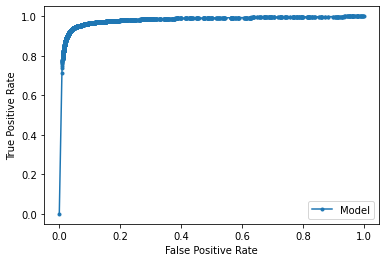

In [ ]:
lr_auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
# summarize scores

print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(datahead['y_real'],datahead['y_predfrac1'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.942 auc=0.978


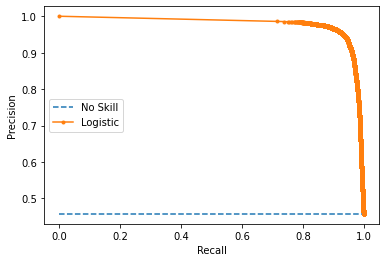

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(datahead['y_real'],datahead['y_predfrac1'])
lr_f1, lr_auc = f1_score(datahead['y_real'], datahead['y_pred']), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(datahead['y_real'][datahead['y_real']==1]) / len(datahead['y_real'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
precision, recall, thresholds  = precision_recall_curve(datahead['y_real'], datahead['y_predfrac1'])
auc_score = metrics.auc(recall, precision)
auc_score

0.9781162365908576